## CatBoost Regressor Model:

### Introduction to CatBoost and Gradient Boosting:

Here, we build a CatBoostRegressor model using the cleaned and transformed data from the previous step. CatBoost is a variant of the Gradient Boosting algorithm. Gradient Boosting is an ensemble method that involves training learners based upon minimizing the differential loss function of a weak learner using a gradient descent optimization process.

The architecture is sequential, where decision trees are added stage-wise in series. Gradient Boosting, in general, focuses on reducing the bias. To avoid potential overfitting issues, it is imperative to optimize parameters such as the regularization strength, tree depth and the no. of estimators.

#### Gradient Descent Algorithm:

The algorithm uses an iterative sequence to update the model by stacking improved versions of the learners. This is achieved by solving an optimization problem at each step - minimizing the gradient of the loss function. The steps of the algorithm are detailed below:

Step 1: Initialize the boosting model:

$ F_0(x) = \underset{\gamma}{\mathrm{arg\,min}}\ \sum_{i=1}^{n} L(y_i, \gamma) $

For $ m = 1, \ldots, M $:

Step 2: Evaluate the residuals (derivatives of the loss function):

$ r_{im} = - \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{ (x)=F_{m-1}(x)} \quad \text{for } i = 1, \ldots, n $

Step 3: Fit a weak learner $ h_m(x) $ (decision tree) to the residuals.

Step 4: Compute the multiplier $ \gamma_m $ by solving the following optimization problem:

$ \gamma_m = \underset{\gamma}{\mathrm{arg\,min}}\ \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)) $

Step 5: Update the model by stacking the improved learners in series:

$ F_m(x) = F_{m-1}(x) + \gamma_m h_m(x) $

The final boosted model is given by $ F_M(x) $, where $ M $ is the no. of estimators / weak learners in series.

#### Why CatBoost:

CatBoost has a number of key characteristics which make it better for data with many categorical variables and for noisy data which can be susceptible to overfitting. Gradient Boosting, in general, is a greedy algorithm, which has a tendency to overfit the data and CatBoost helps to avoid that.

1) Encoding of categorical features: CatBoost uses Ordered Target Encoding where the categories are encoded using the target over several random permutations to avoid target leakage. This works well when dealing with high cardinality features as the dimensionality of the encoded set is significantly smaller than other encoding methods such as One-Hot Encoding.

2) Ordered boosting: CatBoost trains the model on a subset of data while calculating residuals on another subset. ​This is in contrast to XGBoost and LightGBM, where the same data instance is used for both training and estimating the gradients. This allows the model to work with unseen data and helps in avoiding overfitting.

Balanced architecture: CatBoost builds symmetric (balanced) trees unlike XGBoost and LightGBM which have asymmetric trees. In CatBoost, the feature-pair which yields the lowest log-loss is used for the split point condition at every level of the decision tree. This makes it computationally more efficient and helps in avoiding overfitting.

### Model Configuration and Implementation:

#### Installing and importing the necessary packages:

In [ ]:
!pip install catboost --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 15.6 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install shap --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import shap
import csv
import pandas as pd

#### Importing the Dataset:

Here, we first need to upload the necessary files onto the Google Colab server. The cleaned and engineered dataset in .csv format is imported as a Pandas DataFrame. Also, the .csv files for manual identification of numeric and categorical features are imported as lists which will be passed to the CatBoostRegressor model during initialization.

In [ ]:
## Import the cleaned, engineered dataset:

df_filtered = pd.read_csv('./filtered_sales_data_SP500_04_23.csv', low_memory=False)
df_filtered = df_filtered.drop(columns=['Unnamed: 0'], axis=1)

Y = df_filtered["sale_price"] # target variable
df_filtered = df_filtered.drop(columns=['sale_price'], axis=1) # feature matrix

## Categorical columns:

categorical_cols = []
file_name = './categorical_col_names_SP500_04_23.csv'
with open(file_name, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        categorical_cols.append(row[0])
df_filtered[categorical_cols] = df_filtered[categorical_cols].astype('category')

## Numerical columns:

numerical_cols = []
file_name = './numerical_col_names_SP500_04_23.csv'
# Open the CSV file and read its contents into the list
with open(file_name, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        numerical_cols.append(row[0])

# print(categorical_cols)
# print(len(categorical_cols))
# print(numerical_cols)
# print(len(numerical_cols))

print(df_filtered.shape)
# print(df_filtered.dtypes)

(145027, 58)


#### Standardization:

Here, we apply standard scaling on the numeric features in X. This ensures that biasing of the features due to magnitude differences are not going to affect the predictions. Standard scaling normalizes every numeric feature such that it has a mean of 0 and standard deviation of 1.

$ \bar{x} = \frac{x - \mu}{\sigma} $

In [ ]:
## Standardize the feature matrix:

y = Y

numeric_features = numerical_cols
categorical_features = categorical_cols

## Standardizing the numerical features:

X_numeric = df_filtered[numeric_features]
ss = StandardScaler()
ss.fit(X_numeric)
X_numeric_scaled = ss.transform(X_numeric)

X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=X_numeric.columns)
df_filtered.update(X_numeric_scaled_df)

df_filtered.head()

for col in categorical_features:
    df_filtered[col] = df_filtered[col].astype(str).fillna('Missing')

df_filtered.head()

,BsmtCode,CD,Council,HealthCent,IrrLotCode,LandUse,LotType,PolicePrct,SchoolDist,TaxMap,...,zip_code_rank,years_since_built,years_since_last_alteration,years_since_sold,avg_sale_price_3m,avg_sale_price_1y,avg_sale_price_2y,SP500_price_day_close,IYR_price_day_close,inflation_CPI_annual
0,1.0,318.0,46.0,33.0,N,1.0,5.0,69.0,18.0,32406.0,...,1.148952,-1.044957,-0.527906,1.338175,-1.700317,-1.665356,-1.628208,-1.331606,-1.825907,0.035356
1,0.0,301.0,33.0,30.0,N,6.0,5.0,94.0,14.0,30904.0,...,-1.808328,-1.984190,-1.259702,1.338175,-1.111787,-1.056540,-0.990429,-1.331606,-1.825907,0.035356
2,0.0,301.0,33.0,30.0,N,6.0,5.0,94.0,14.0,30904.0,...,-1.808328,-2.286087,-1.494922,1.338175,-0.970545,-0.910429,-0.837368,-1.331606,-1.825907,0.035356
3,5.0,301.0,33.0,30.0,N,6.0,5.0,94.0,14.0,30904.0,...,-1.808328,-2.286087,-1.494922,1.338175,-0.899924,-0.837374,-0.760838,-1.331606,-1.825907,0.035356
4,5.0,301.0,33.0,30.0,N,6.0,5.0,94.0,14.0,30904.0,...,-1.808328,-2.286087,-1.494922,1.338175,-0.857552,-0.793541,-0.714919,-1.331606,-1.825907,0.035356


#### Split Data into train/test/validation Sets:

Next, we split the dataset into train/test/validation sets. First, a train/test split of 80/20 is used. From the training set, around 25 % of the data is randomly drawn as a validation subset. This set will be exclusively used for hyperparameter tuning. Once the optimal values of the hyperparameters are found, the "best" model will be trained on the full training set.

In [ ]:
## Create training, testing and validation sets:

X = df_filtered

filtered_indices = y < 1e7
X = X[filtered_indices]
y = y[filtered_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### Model Initialization:

Loss function was set as RMSE.​

“one_hot_max_size” was set to 2 to ensure that categorical features with more than 2 categories are encoded using Ordered Target Encoding.​

The list of categorical features were passed to the model explicitly.​

“early_stopping_rounds” was set to 100 to reduce training time. This stops the training for each learner if improvement in the loss function is not observed for more than 100 iterations.

In [ ]:
'''
class CatBoostRegressor(iterations=None,
                        learning_rate=None,
                        depth=None,
                        l2_leaf_reg=None,
                        model_size_reg=None,
                        rsm=None,
                        loss_function='RMSE',
                        border_count=None,
                        feature_border_type=None,
                        per_float_feature_quantization=None,
                        input_borders=None,
                        output_borders=None,
                        fold_permutation_block=None,
                        od_pval=None,
                        od_wait=None,
                        od_type=None,
                        nan_mode=None,
                        counter_calc_method=None,
                        leaf_estimation_iterations=None,
                        leaf_estimation_method=None,
                        thread_count=None,
                        random_seed=None,
                        use_best_model=None,
                        best_model_min_trees=None,
                        verbose=None,
                        silent=None,
                        logging_level=None,
                        metric_period=None,
                        ctr_leaf_count_limit=None,
                        store_all_simple_ctr=None,
                        max_ctr_complexity=None,
                        has_time=None,
                        allow_const_label=None,
                        one_hot_max_size=None,
                        random_strength=None,
                        name=None,
                        ignored_features=None,
                        train_dir=None,
                        custom_metric=None,
                        eval_metric=None,
                        bagging_temperature=None,
                        save_snapshot=None,
                        snapshot_file=None,
                        snapshot_interval=None,
                        fold_len_multiplier=None,
                        used_ram_limit=None,
                        gpu_ram_part=None,
                        pinned_memory_size=None,
                        allow_writing_files=None,
                        final_ctr_computation_mode=None,
                        approx_on_full_history=None,
                        boosting_type=None,
                        simple_ctr=None,
                        combinations_ctr=None,
                        per_feature_ctr=None,
                        ctr_target_border_count=None,
                        task_type=None,
                        device_config=None,
                        devices=None,
                        bootstrap_type=None,
                        subsample=None,
                        sampling_unit=None,
                        dev_score_calc_obj_block_size=None,
                        max_depth=None,
                        n_estimators=None,
                        num_boost_round=None,
                        num_trees=None,
                        colsample_bylevel=None,
                        random_state=None,
                        reg_lambda=None,
                        objective=None,
                        eta=None,
                        max_bin=None,
                        gpu_cat_features_storage=None,
                        data_partition=None,
                        metadata=None,
                        early_stopping_rounds=None,
                        cat_features=None,
                        grow_policy=None,
                        min_data_in_leaf=None,
                        min_child_samples=None,
                        max_leaves=None,
                        num_leaves=None,
                        score_function=None,
                        leaf_estimation_backtracking=None,
                        ctr_history_unit=None,
                        monotone_constraints=None,
                        feature_weights=None,
                        penalties_coefficient=None,
                        first_feature_use_penalties=None,
                        model_shrink_rate=None,
                        model_shrink_mode=None,
                        langevin=None,
                        diffusion_temperature=None,
                        posterior_sampling=None,
                        boost_from_average=None,
                        fixed_binary_splits=None)
'''

"\nclass CatBoostRegressor(iterations=None,\n                        learning_rate=None,\n                        depth=None,\n                        l2_leaf_reg=None,\n                        model_size_reg=None,\n                        rsm=None,\n                        loss_function='RMSE',\n                        border_count=None,\n                        feature_border_type=None,\n                        per_float_feature_quantization=None,\n                        input_borders=None,\n                        output_borders=None,\n                        fold_permutation_block=None,\n                        od_pval=None,\n                        od_wait=None,\n                        od_type=None,\n                        nan_mode=None,\n                        counter_calc_method=None,\n                        leaf_estimation_iterations=None,\n                        leaf_estimation_method=None,\n                        thread_count=None,\n                        random_seed=

In [ ]:
## CatBoostRegressor Model initialization:

gbr = CatBoostRegressor(loss_function='RMSE', random_state=42, one_hot_max_size=2, cat_features=categorical_features, early_stopping_rounds=100)

#### Hyperparameter Tuning - Bayesian Optimization:

A smaller validation set instead of the entire training set is used for hyperparameter tuning for faster convergence.​ Bayesian optimization is used for finding the optimal values of the hyperparameters over a specified search space.​ 5-fold cross-validation is performed with each iteration to avoid overfitting.

Essentially, it is a black-box optimizer which models the objective function on the basis of a Gaussian probability distribution and determines the hyperparameter values which would minimize that function. The sampling in the search space is done by acquisition functions. Each iteration of sampling the space attempts to maximize the acquisiton function value, i.e., reach a trade-off between exploration and exploitation.

The Gaussian process is updated with the prior (previous iteration) to get a new posterior that better approximates the objective function.

The Bayesian optimization procedure is as follows:


For $ t = 1, 2, $
Find the next sampling point $( x_t )$ by optimizing the acquisition function $ (u) $ over the GP:

$ x_t = \underset{x}{\text{arg max}}\; u(x|D_{t-1}) $


Obtain a possibly noisy sample $( y_t = f(x_t) + \epsilon_t )$ from the objective function $( f )$.


Add the sample to previous samples $ D_t := D_{t-1}, (x_t, y_t) $ and update the GP.

The following hyperparameters were considered:​

iterations – equivalent to the no. of estimators – measure of overall model complexity.​

learning_rate – equivalent to the step-size in the optimization problem – controls the speed of convergence.​

depth – the max. depth of each decision tree – measure of complexity of each estimator.​

l2_leaf_reg – equivalent to the regularization strength in LASSO – controls the overfitting.

In [ ]:
## Hyperparameter tuning - using Bayesian Optimizer:
## Initialize the tuner:

'''
iterations
learning_rate
depth
l2_leaf_reg
'''
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define the upper and lower limits for the hyperparameter search space:

search_spaces = {
    'depth': Integer(2, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'iterations': Integer(100, 1000),
    'l2_leaf_reg': Integer(0, 5)
}

In [ ]:
## Find the best estimator:

bayes_tuner = BayesSearchCV(
    estimator=gbr,
    search_spaces=search_spaces,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=100,
    refit=True,
    random_state=42
)

bayes_tuner.fit(X_val, y_val) # use the validation sets for hyperparameter tuning
best_model = bayes_tuner.best_estimator_
best_params = bayes_tuner.best_params_
print('The optimal hyperparameter set for CatBoostRegressor:', best_params)

Streaming output truncated to the last 5000 lines.
776:	learn: 278615.2841824	total: 27.5s	remaining: 7.9s
777:	learn: 278420.6867393	total: 27.6s	remaining: 7.86s
778:	learn: 278361.3387509	total: 27.6s	remaining: 7.83s
779:	learn: 278253.1956284	total: 27.6s	remaining: 7.79s
780:	learn: 277991.9877825	total: 27.7s	remaining: 7.76s
781:	learn: 277874.5351856	total: 27.7s	remaining: 7.72s
782:	learn: 277778.9129797	total: 27.7s	remaining: 7.69s
783:	learn: 277673.5444677	total: 27.8s	remaining: 7.65s
784:	learn: 277579.6098266	total: 27.8s	remaining: 7.62s
785:	learn: 277448.3709473	total: 27.8s	remaining: 7.58s
786:	learn: 277269.4601415	total: 27.9s	remaining: 7.54s
787:	learn: 277225.9108272	total: 27.9s	remaining: 7.51s
788:	learn: 277095.0393578	total: 27.9s	remaining: 7.47s
789:	learn: 276983.0647205	total: 28s	remaining: 7.44s
790:	learn: 276887.5409884	total: 28s	remaining: 7.4s
791:	learn: 276772.3747027	total: 28s	remaining: 7.37s
792:	learn: 276630.0023653	total: 28.1s	remai

In [ ]:
print('The optimal hyperparameter set for CatBoostRegressor:', best_params)

The optimal hyperparameter set for CatBoostRegressor: OrderedDict([('depth', 8), ('iterations', 1000), ('l2_leaf_reg', 0), ('learning_rate', 0.037827822913573624)])


All hyperparameters except the no. of iterations, have converged to a point within the search space. The no. of iterations converged to the upper limit of the search space, so we try to see if further improvements (however marginal) can be obtained by further increasing the no. of iterations. For this, we use a simple grid search.

In [ ]:
## Fine-tune the hyperparameters using GridSearchCV:

param_grid = {
    'depth': [best_params['depth']],
    'learning_rate': [best_params['learning_rate']],
    'iterations': [1000, 1250, 1500, 1750, 2000, 2250, 2500],
    'l2_leaf_reg': [best_params['l2_leaf_reg']]
}

grid_search_tuner = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=2
)

grid_search_tuner.fit(X_val, y_val)
best_model = grid_search_tuner.best_estimator_
best_params = grid_search_tuner.best_params_
print('The optimal hyperparameter set for CatBoostRegressor:', best_params)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
0:	learn: 840464.8797377	total: 34.9ms	remaining: 1m 9s
1:	learn: 824536.4677531	total: 71.3ms	remaining: 1m 11s
2:	learn: 810116.0327132	total: 110ms	remaining: 1m 13s
3:	learn: 796207.9518802	total: 146ms	remaining: 1m 12s
4:	learn: 782659.6608673	total: 189ms	remaining: 1m 15s
5:	learn: 770308.5155885	total: 226ms	remaining: 1m 15s
6:	learn: 758027.4073071	total: 271ms	remaining: 1m 17s
7:	learn: 746457.2628933	total: 307ms	remaining: 1m 16s
8:	learn: 735741.3649454	total: 348ms	remaining: 1m 17s
9:	learn: 725081.3086941	total: 383ms	remaining: 1m 16s
10:	learn: 715169.2927278	total: 424ms	remaining: 1m 16s
11:	learn: 704777.8012424	total: 454ms	remaining: 1m 15s
12:	learn: 695096.8659726	total: 496ms	remaining: 1m 15s
13:	learn: 686369.2107181	total: 530ms	remaining: 1m 15s
14:	learn: 677662.9472385	total: 575ms	remaining: 1m 16s
15:	learn: 669674.5817356	total: 609ms	remaining: 1m 15s
16:	learn: 661401.9279333	total: 649m

#### Training the "Best" Model:

In [ ]:
## Retrain the optimal model instance on the full training set:
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, cat_features=categorical_features)

0:	learn: 845663.8319791	test: 839681.0144563	best: 839681.0144563 (0)	total: 128ms	remaining: 4m 14s
1:	learn: 829728.1067379	test: 823443.5013137	best: 823443.5013137 (1)	total: 241ms	remaining: 4m 1s
2:	learn: 814367.6012935	test: 807808.2682273	best: 807808.2682273 (2)	total: 353ms	remaining: 3m 55s
3:	learn: 799908.2264343	test: 793192.9501588	best: 793192.9501588 (3)	total: 444ms	remaining: 3m 41s
4:	learn: 785993.2836805	test: 779084.7081449	best: 779084.7081449 (4)	total: 545ms	remaining: 3m 37s
5:	learn: 772720.9413272	test: 765705.1439758	best: 765705.1439758 (5)	total: 651ms	remaining: 3m 36s
6:	learn: 759855.1351114	test: 752721.4016294	best: 752721.4016294 (6)	total: 758ms	remaining: 3m 35s
7:	learn: 747772.7737827	test: 740692.9041676	best: 740692.9041676 (7)	total: 855ms	remaining: 3m 32s
8:	learn: 736345.3163818	test: 729165.0902413	best: 729165.0902413 (8)	total: 953ms	remaining: 3m 30s
9:	learn: 725526.5548919	test: 718096.6285904	best: 718096.6285904 (9)	total: 1.05s

### Results and Analysis:

#### Evaluate on the Test Set:

Next, we use the trained model to evaluate the predictions on the test set and compare it with the actual $ y $ values. The $ r^{2} $ and MSE are evaluated.

$ R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \overline{y})^2} $

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 $

In [ ]:
## Run the predictions on the test set and evaluate metrics:

y_pred = best_model.predict(X_test)

ss_test = StandardScaler()
y_test_scaled = ss_test.fit_transform(y_test.values.reshape(-1, 1))
ss_pred = StandardScaler()
y_pred_scaled = ss_pred.fit_transform(y_pred.reshape(-1, 1))

mse = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)
print('R2 score on the test set:', r2)
print('MSE on the normalized test set:', mse)
print('RMSE on the normalized test set:', rmse)

R2 score on the test set: 0.7258088924715101
MSE on the normalized test set: 0.29595201044703145
RMSE on the normalized test set: 0.5440147152853785


#### Result Plots:

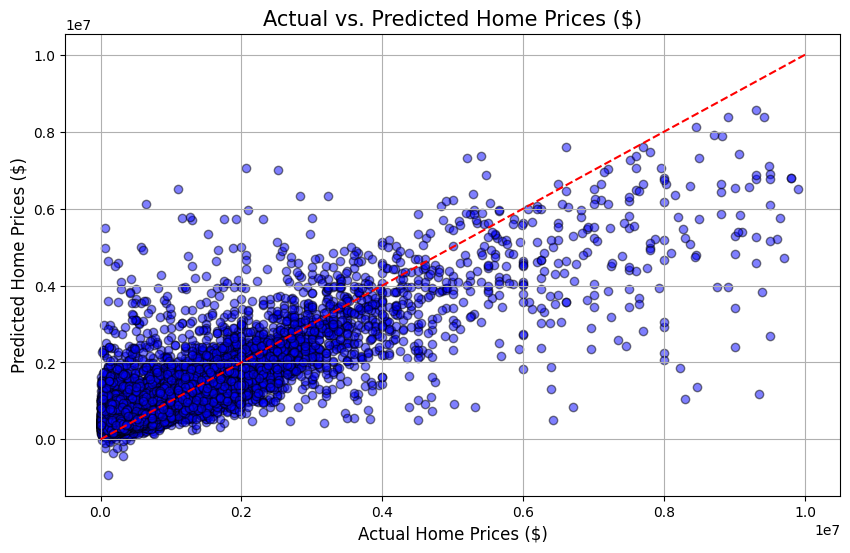

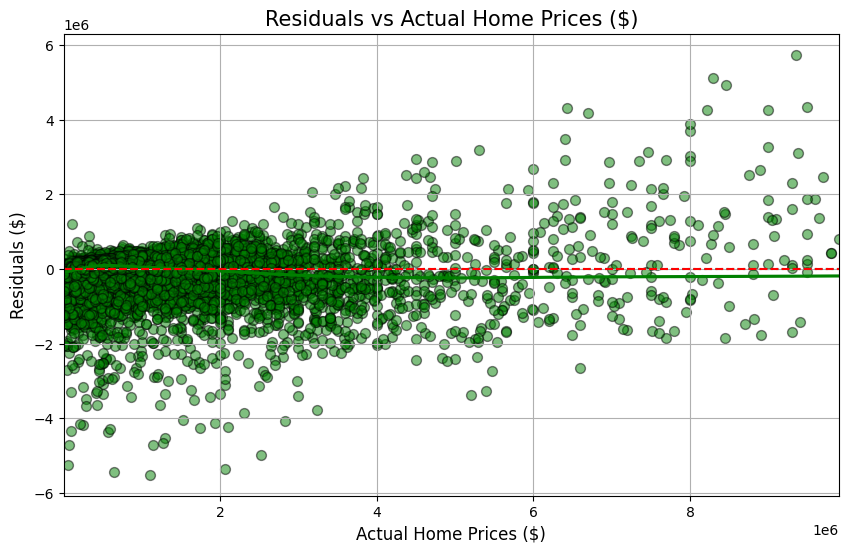

In [ ]:
## Visualize the results:

# Predicted vs. actual values:

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, edgecolor='k')
plt.plot([0, 1e7], [0, 1e7], 'r--', label='Perfect Prediction Line')
plt.title('Actual vs. Predicted Home Prices ($)', fontsize=15)
plt.xlabel('Actual Home Prices ($)', fontsize=12)
plt.ylabel('Predicted Home Prices ($)', fontsize=12)
plt.grid(True)
plt.xlim(-0.05e7, 1.05e7)

# Residuals plot:

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=residuals, lowess=True, color="g", scatter_kws={'alpha':0.5, 's':50, 'edgecolor':'k'})
plt.title('Residuals vs Actual Home Prices ($)', fontsize=15)
plt.xlabel('Actual Home Prices ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

#### Feature Importance Analysis:

The feature importance is a measure of the weight of a feature to the overall prediction. The most important features which heavily affect the predictions in the optimized model are listed in order.

In [ ]:
## Feature importance analysis:

feat_importances = best_model.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,AssessTot,10.863318
1,gross_sqft,4.865939
2,avg_sale_price_2y,4.393147
3,neighborhood,4.297213
4,building_class_category,4.289591
5,zip_code_rank,3.762093
6,CD,3.753430
7,avg_sale_price_1y,3.739489
8,SP500_price_day_close,3.506206
9,years_since_sold,2.954479


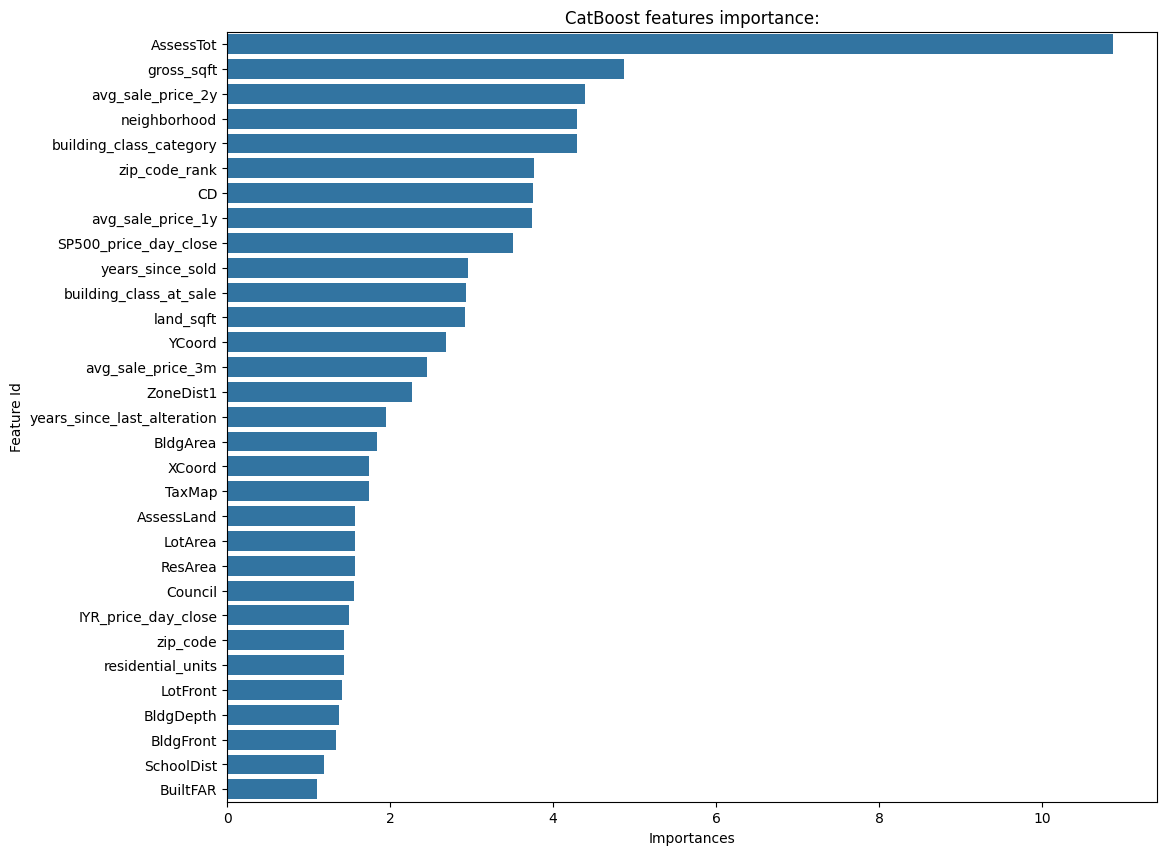

In [ ]:
## Plot:

plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:');

We can see the high importance of a number of categorical variables related to the location such as ‘neighborhood’, ‘zip_code_rank’ and ‘CD’. This tells us that there is further scope to engineer the features and possibly combine these features into a proxy variable that encompasses the location-related details such as ‘zip_code_rank’ which would simplify the model without losing out on prediction accuracy and performance.

Also, the temporal aspect of the dataset is well-accounted for by the model considering the importances of the features such as ‘SP500_price_day_close’ and ‘years_since_sold’. These features were engineered to mimic the changes and fluctuations in market values including periods of recession (confounding factor). They contribute heavily to the final predictions as expected.


Another way of visualizing the feature importances is by SHAP values. SHAP (SHapley Additive ExPlanations) value is measure of the contribution of each feature to the overall prediction. ​The location of the dot horizontally shows the impact of that feature on the model’s output for that prediction. Features pushing the prediction higher are shown in red and those pushing the prediction lower are in blue.​ A SHAP value of zero means the feature did not change the prediction from the base value (the model’s average prediction over the training set). The further away from zero, the more impact the feature has.​ A vertical line of many dots suggests a common impact on the prediction, while scattered dots indicate varying impacts.

In [ ]:
## SHAP Plots:

for col in categorical_features:
    X_train[col] = X_train[col].astype(str).fillna('Missing')

for col in categorical_features:
    X_test[col] = X_test[col].astype(str).fillna('Missing')

train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_data = Pool(data=X_val, label=y_val, cat_features=categorical_features)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train_data)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

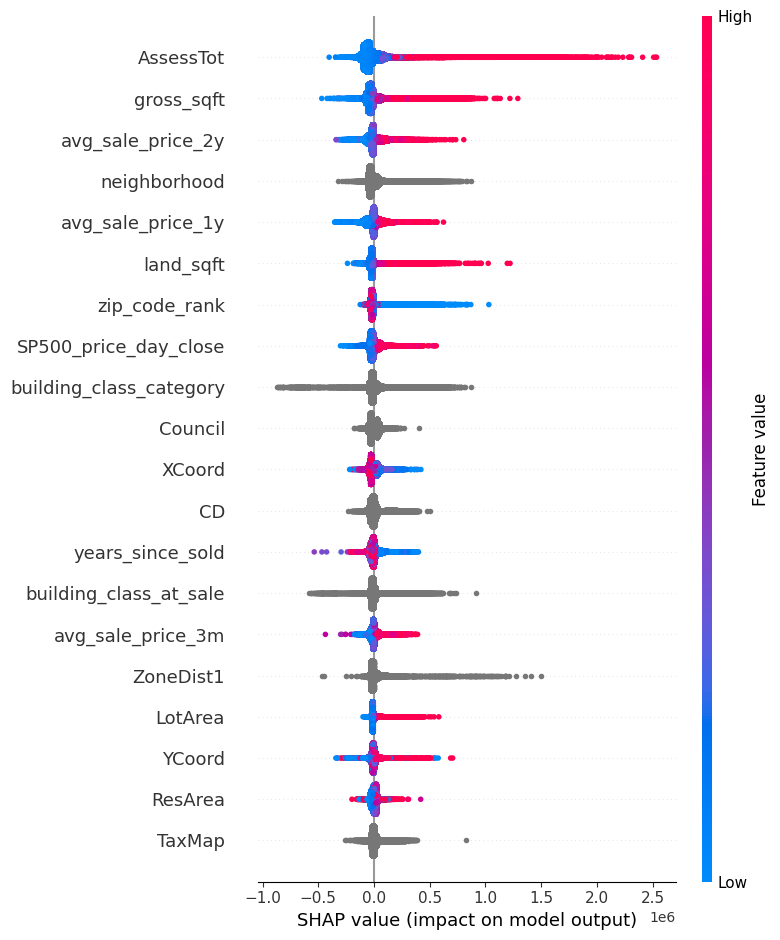

In [ ]:
shap.summary_plot(shap_values, X_train)